In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Konlpy

import os
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings(action = 'ignore')
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Kkma, Okt
import pickle
import tqdm
from gensim import models

import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, SpatialDropout1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 460kB 59.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [3]:
train = pd.read_csv('/content/drive/My Drive/news_spam/1_news_train.csv')
test = pd.read_csv('/content/drive/My Drive/news_spam/1_news_test.csv')

In [4]:
train.head(10)

,n_id,date,title,content,ord,info
0,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,제목 : 신송홀딩스(006880) 급등세 기록중 +12.73%,1,1
1,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,기업개요,2,1
2,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,"펀드매니저들이 받아보는 모바일 주식신문. 매일2회 휴대폰으로 전송 (오전7시,오후6시반)",3,0
3,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,"개인/외국인/기관 일별 순매매동향(수량기준, 전일까지 5거래일)",4,1
4,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,종목히스토리,5,1
5,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,종목 이슈,6,1
6,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,종목 공시,7,1
7,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,이슈&amp;테마 스케줄,8,1
8,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,관련 테마분석,9,0
9,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,지주사 테마 개요 및 관련종목 리스트 바로보기,10,0


In [ ]:
train.head(10)

,n_id,date,title,content,ord,info
0,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,제목 : 신송홀딩스(006880) 급등세 기록중 +12.73%,1,1
1,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,기업개요,2,1
2,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,"☞펀드매니저들이 받아보는 모바일 주식신문! 매일2회 휴대폰으로 전송 (오전7시,오후...",3,0
3,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,"개인/외국인/기관 일별 순매매동향(수량기준, 전일까지 5거래일)",4,1
4,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,종목히스토리,5,1
5,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,▶종목 이슈,6,1
6,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,▶종목 공시,7,1
7,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,이슈&amp;테마 스케줄,8,1
8,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,관련 테마분석,9,0
9,NEWS00000,20200504,신송홀딩스(006880) 급등세 기록중 +12.73%,▶지주사☞ 테마 개요 및 관련종목 리스트 바로보기,10,0


In [5]:
y = train['info'].value_counts()
print(y)

1    62577
0    30975
Name: info, dtype: int64


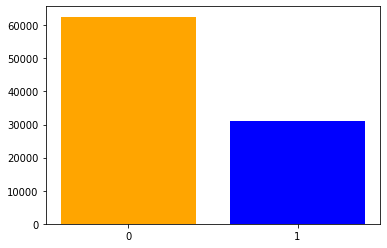

In [6]:
plt.bar(["0","1"],y, color = ['orange', 'blue'])
plt.show()

Max of sentence length is 593 
Min of sentence length is 1 
Mean of sentence length is 11.868586454592098 


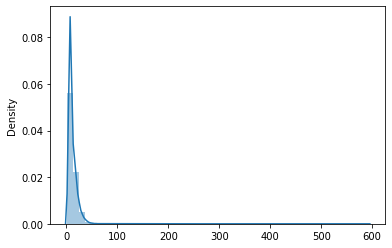

In [7]:
#문장의 길이
question = train['content']
number_of_words = []
for i in question:
    number_of_words.append(len(i.split(" ")))
    
print('Max of sentence length is {} '.format(max(number_of_words)))
print('Min of sentence length is {} '.format(min(number_of_words)))
print('Mean of sentence length is {} '.format(np.mean(number_of_words)))

sns.distplot(number_of_words)

Max of sentence length is 969 
Min of sentence length is 1 
Mean of sentence length is 16.075285347565664 


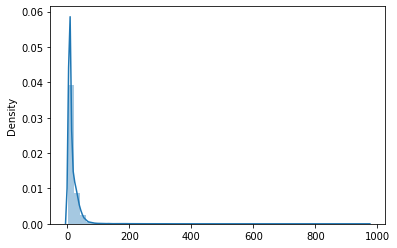

In [ ]:
#문장의 길이
question = test['content']
number_of_words = []
for i in question:
    number_of_words.append(len(i.split(" ")))
    
print('Max of sentence length is {} '.format(max(number_of_words)))
print('Min of sentence length is {} '.format(min(number_of_words)))
print('Mean of sentence length is {} '.format(np.mean(number_of_words)))

sns.distplot(number_of_words)

In [ ]:
#긴 문장 자르기
lifeExp_greather_80 = df['lifeExp'] >= 80

In [ ]:
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null']
    tokenizer = Okt()
    bigram_list = []
    
    for text in tqdm.tqdm(text_list):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        txt = re.sub('x{1,}', ' ', txt)
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords or type(t) != float]
        bigram = [token[i] + '.' + token[i+1] for i in range(len(token) - 1)]
        bigram_list.append(' '.join(bigram))
        
    return bigram_list, tokenizer

train['bigram'], okt = text_preprocessing(train['content'])

 66%|██████▌   | 61384/93552 [03:14<01:32, 346.74it/s]

In [ ]:
def text2sequence(train_text, max_len=1000):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len)
    return X_train, vocab_size, tokenizer

In [ ]:
train_y = train['info']
train_X, vocab_size, sequncer = text2sequence(train['bigram'], max_len = 100)
print(train_X.shape, train_y.shape)

vocab_size :  52028
(70061, 100) (70061,)


In [ ]:
pd.Series([len(x.split()) for x in train['bigram']]).describe()

count    70061.000000
mean        24.910264
std         36.259607
min          0.000000
25%          7.000000
50%         13.000000
75%         33.000000
max       1283.000000
dtype: float64

In [ ]:
auc_ = 0
def auc_score(y_true, y_pred):
    global auc_
    try:
        auc_ = roc_auc_score( y_true, y_pred, average='macro', sample_weight = None).astype('float32')
    except ValueError:
        pass
    return auc_

def auc(y_true, y_pred):
    score = tf.compat.v1.py_func( lambda y_true, y_pred : auc_score(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'sklearnAUC' )
    return score

In [ ]:
def BiLSTM(vocab_size, max_len=1000):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_len))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc])
    model.summary()
    return model

In [ ]:
print('START TIME: ', datetime.now().isoformat())
model = BiLSTM(vocab_size, max_len=100)
early_stopping = EarlyStopping(patience=3, min_delta=0.00001)
history = model.fit(train_X, train_y, epochs=3, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

print('END TIME: ', datetime.now().isoformat())

START TIME:  2020-10-30T03:37:08.610865
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          6659584   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,766,721
Trainable params: 6,766,721
Non-trainable params: 0
______

In [ ]:
for i in range(1,100):
    if test['info'][i] == 1:
        print(test['content'][i])
        print('\n')

26일 한국감정원의 '2020년 3월 4주 주간아파트 가격동향' 자료를 보면 지난 23일 기준 서울 아파트값 상승률은 전주와 동일하게 0%를 유지했다.


한국감정원은 "코로나19 영향에 따른 대내외적 경제위기와 공시가격 인상, 자금출처 증빙강화 등으로 매수심리가 위축되고, 보유세 부담이 커진 고가주택 위주로 하락세가 확대됐다"고 분석했다.


강남(-0.14%)·서초(-0.14%)·송파구(-0.10%) 등 강남3구도 대출규제와 공시가격 상승에 따른 보유세 부담 등의 영향으로 15억원 초과 단지 위주로 하락세가 지속돼 전주 대비 하락폭이 커졌다. 강남권의 경우 급매물이 늘어나고 매수문의는 줄어 당분간 집값 하락이 이어질 것이란 분석이 나온다.


지난주 0.01% 상승한 강동구(0.00%)는 가격대별 혼조세를 보이며 보합세로 전환했다. 강남4구 이외에 한강 이남에서는 대체로 안정세가 이어지는 가운데, 금천구(0.04%)는 역세권 및 신축 위주로, 관악구(0.04%)는 봉천·신림동 위주로 가격이 상승했다.


마포(0.03%)·용산(0.01%)·성동구(0.00%) 등 강북 14개구는 모두 상승세가 둔화되거나 유지됐다. 중저가 아파트 단지가 많고 개발호재가 있어 그동안 상대적으로 높은 상승률을 보였던 노원(0.05%)·도봉(0.06%)·강북구(0.06%)도 상승폭이 축소했다.


인천과 경기도도 이와 비슷한 흐름을 보였다. 인천은 전주(0.53%) 대비 0.42% 올라 상승폭이 축소했다. 미추홀구(0.51%)는 정주여건이 양호한 용현·학익동 신축 및 준신축 위주로, 남동구(0.49%)는 교통망 확충(GTX-B, 제2경인선 등) 및 정비사업 진척 기대감이 있는 간석·구월·논현동 위주로 상승했다.


경기도는 전주(0.40%) 대비 0.28% 올라 상승폭이 뚝 떨어졌다. 신분당선 연장 호재와 비규제지역 등의 영향으로 상승폭이 높았던 수원시(0.25%)는 규제강화와 코로나19 사태, 급등 피로감 등으로 매수심리가 위축되며 상승세가 큰 폭으로 감소했다.


조정대상지역으

In [ ]:
for i in range(1,100):
    if test['info'][i] == 0:
        print(test['content'][i])
        print('\n')

●中, 코로나 바이러스 확산.. 반사 이익 수혜주는!? (테마주 단타 공략 무료 체험)


●이번주, 上한가 임박 직전 급등주 확인


●소름 주의! 올해 대박 나는 기회가 찾아올까?[관련기사]☞


음악이 있는 시 낭송회 '아우내의 새' 오후 3시부터 유튜브 생중계☞


美 상원 2700조원 규모 경기부양 패키지 통과…'역대 최대'☞


인천 연수구서 유럽 3개국 여행 20대 여성 확진☞


딥서치, 여의도 금융대학원 운영기관에 선정☞


트렌드 한 입, 즐거움 한 잔! 색다른 즐거움, 드링킷


FX마진거래의 이슈, FX시티 천안점 살펴보기매수와 매도의 개념, 그리고 마틴이란 무엇인가?


신종코로나 바이러스 1000% 갈 新 대장주가 단돈 1천원대? (즉시확인)2020년 주식농사 한 방에 끝낼 단 하나의 종목 긴급 공개


●中, 코로나 바이러스 확산.. 반사 이익 수혜주는!? (테마주 단타 공략 무료 체험)


●이번주, 上한가 임박 직전 급등주 확인


●소름 주의! 올해 대박 나는 기회가 찾아올까?[관련기사]☞


'이낙연TV' vs '황교안오피셜'…총선 격전지 종로, 유튜브 대전 본격화☞


조주빈, 수사혼선 주려 가짜 계좌 알려줘…"3개 중 2개는 가짜"☞


서울 '코로나19' 확진자 밤 사이 16명 늘어 … 11명이 해외입국자☞


늘어나는 급매물…서울 아파트값 하락세 '초읽기'☞


트렌드 한 입, 즐거움 한 잔! 색다른 즐거움, 드링킷


FX마진거래의 이슈, FX시티 천안점 살펴보기매수와 매도의 개념, 그리고 마틴이란 무엇인가?


신종코로나 바이러스 1000% 갈 新 대장주가 단돈 1천원대? (즉시확인)2020년 주식농사 한 방에 끝낼 단 하나의 종목 긴급 공개


▶ 연말 산타랠리 新수혜주로 급부상... 절대 놓쳐선 안 될 '이 종목' (클릭)


▶▶[무료 공개]◀◀ "100만원"만 있어도 지금 당장 "이것"부터 사라!! >>> (바로확인)


◆◆100%추가급등 예상◆◆ 개별주 장세 후속테마 TOP 3 (지금 추천받기)


최저금

In [ ]:
test_y = test['info'].value_counts()
print(test_y)

1    38807
0    30144
Name: info, dtype: int64


In [ ]:
def test_preprocessing(text_list, tokenizer):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null']
    tokenizer = tokenizer
    bigram_list = []
    
    for text in tqdm.tqdm(text_list):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        txt = re.sub('x{1,}', ' ', txt)
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords or type(t) != float]
        bigram = [token[i] + '.' + token[i+1] for i in range(len(token) - 1)]
        bigram_list.append(' '.join(bigram))
        
    return bigram_list


test['bigram']= test_preprocessing(test['content'], okt)

100%|██████████| 68951/68951 [05:13<00:00, 220.03it/s]


In [ ]:
def test2sequence(test_text, max_len=1000):
    
    tokenizer = sequncer
    test_X_seq = tokenizer.texts_to_sequences(test_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_test = pad_sequences(test_X_seq, maxlen = max_len)
    return X_test, vocab_size

In [ ]:
X_test, vocab_size = test2sequence(test['bigram'], max_len = 100)
print(X_test.shape)

vocab_size :  52028
(68951, 100)


In [ ]:
pred = model.predict(X_test)

In [ ]:
pred = pred.reshape(68951)

In [ ]:
binary_pred = list(np.round(pred))

In [ ]:
pd.Series(binary_pred).value_counts()

1.0    39084
0.0    29867
dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score
test_score = accuracy_score(binary_pred, test['info'])
print(test_score)

0.9651491638990007


In [ ]:
np.array(test['info'])[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
import sys

In [ ]:
print(sys.path)
os.listdir('lib')
os.listdir('lib/python3.6')
os.listdir('lib/python3.6/site-packages')

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


FileNotFoundError: ignored

In [ ]:
!ls /usr/local/lib/python3.6/dist-packages

absl
absl_py-0.10.0.dist-info
alabaster
alabaster-0.7.12.dist-info
albumentations
albumentations-0.1.12.dist-info
altair
altair-4.1.0.dist-info
apiclient
argon2
argon2_cffi-20.1.0.dist-info
asgiref
asgiref-3.2.10.dist-info
astor
astor-0.8.1.dist-info
astropy
astropy-4.1.dist-info
astunparse
astunparse-1.6.3.dist-info
async_generator
async_generator-1.10.dist-info
atari_py
atari_py-0.2.6.dist-info
atomicwrites
atomicwrites-1.4.0.dist-info
attr
attrs-20.2.0.dist-info
audioread
audioread-2.1.9.dist-info
autograd
autograd-1.3.dist-info
babel
Babel-2.8.0.dist-info
backcall
backcall-0.2.0.dist-info
beautifulsoup4-4.6.0.dist-info
bin
bleach
bleach-3.2.1.dist-info
blis
blis-0.4.1.dist-info
bokeh
bokeh-2.1.1.dist-info
bottleneck
Bottleneck-1.3.2.dist-info
branca
branca-0.4.1.dist-info
bs4
bs4-0.0.1.dist-info
bson
cachecontrol
CacheControl-0.12.6.dist-info
cachetools
cachetools-4.1.1.dist-info
caffe2
catalogue-1.0.0.dist-info
catalogue.py
certifi
certifi-2020.6.20.dist-info
cffi
cffi-1.14.3.dist

In [ ]:
tokenizer = Okt()

TypeError: ignored